In [1]:
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Earth radius in kilometers
Earth_Radius_KM = 6371

# ref : https://en.wikipedia.org/wiki/Haversine_formula
def haversine_distance(origin: tuple[float, float], destination: tuple[float, float]) -> float:
    '''
        Calculates the haversine distance between two geographic coordinates in kilometers.

        The haversine formula is used to calculate the great-circle distance between two points on a sphere given their geographic coordinates (latitude and longitude). This function takes two tuples of latitude and longitude in degrees, converts them to radians, and returns the distance in kilometers using the Earth's radius.

        Args:
            origin (tuple): A tuple of (latitude, longitude) in degrees for the first location.
            destination (tuple): A tuple of (latitude, longitude) in degrees for the second location.

        Returns:
            float: The distance between the two locations in kilometers.
    '''
    # convert to radians
    origin_lat_rad, origin_lon_rad = map(math.radians, origin)
    dest_lat_rad, dest_lon_rad = map(math.radians, destination)
    
    # differences in coordinates
    diff_in_lat = origin_lat_rad - dest_lat_rad
    diff_in_lon = origin_lon_rad - dest_lon_rad
    
    # haversine formula
    haversine_value = math.sin(diff_in_lat / 2)**2 + math.cos(origin_lat_rad) * math.cos(dest_lat_rad) * math.sin(diff_in_lon / 2)**2
    great_circle_angle = 2 * math.atan2(math.sqrt(haversine_value), math.sqrt(1 - haversine_value))
    
    # return distance in kilometers
    return Earth_Radius_KM * great_circle_angle

In [3]:
# geneate random datasets with distance, ranking index [0, 1000], ranking score [0, 100], and recall score [0, 1]
origin_location = (13.730535078167222, 100.51722744907757)
random_locations = [(13.741460172760418, 100.52945703900683), (13.722747225901431, 100.49704947551552), (13.751713487254452, 100.51226159917519), (13.743477711408703, 100.4995739810327), (13.714646756745294, 100.54927435500979), (13.693737924271923, 100.49201727752865), (13.619711506655612, 100.53902398019436), (13.912907423320988, 100.6063458466953), (13.914512135214704, 100.60634242176562), (13.522935037016458, 100.66803031320607)]

# calculate the distance between the origin and each random location
distance = [haversine_distance(origin_location, location) for location in random_locations]

# ranking index proportional to distance (scaled to [0, 1000])
def calculate_ranking_index(distances):
    # scale distances to [0, 1000]
    return np.clip((distances / 100) * 1000, 0, 1000).astype(int)
# apply the function to each row's distance list
ranking_index = [calculate_ranking_index(d) for d in distance]

# ranking score proportional to ranking index (scaled to [0, 100])
def calculate_inverse_ranking_score(index):
    # inverse proportionality: higher index -> lower score
    epsilon = 1e-5
    score = 1000 / (index + epsilon) 
    # hormalize to 0 to 100 scale
    normalized_score = np.clip(score, 0, 100)
    return normalized_score
ranking_score = np.array([calculate_inverse_ranking_score(index) for index in ranking_index])

# recall score [0, 1]
recall_score = np.random.uniform(0, 1, size=len(random_locations))

df =  pd.DataFrame({
    "Distance": distance,
    "Ranking Index": ranking_index,
    "Ranking Score": ranking_score,
    "Recall Score": recall_score
})
df

,Distance,Ranking Index,Ranking Score,Recall Score
0,1.794646,17,58.823495,0.360110
1,2.345333,23,43.478242,0.239157
2,2.415243,24,41.666649,0.324914
3,2.388966,23,43.478242,0.999506
4,3.886496,38,26.315783,0.436066
5,4.915107,49,20.408159,0.403817
6,12.546020,125,7.999999,0.237461
7,22.446085,224,4.464286,0.876540
8,22.607251,226,4.424779,0.148817
9,28.256856,282,3.546099,0.240428


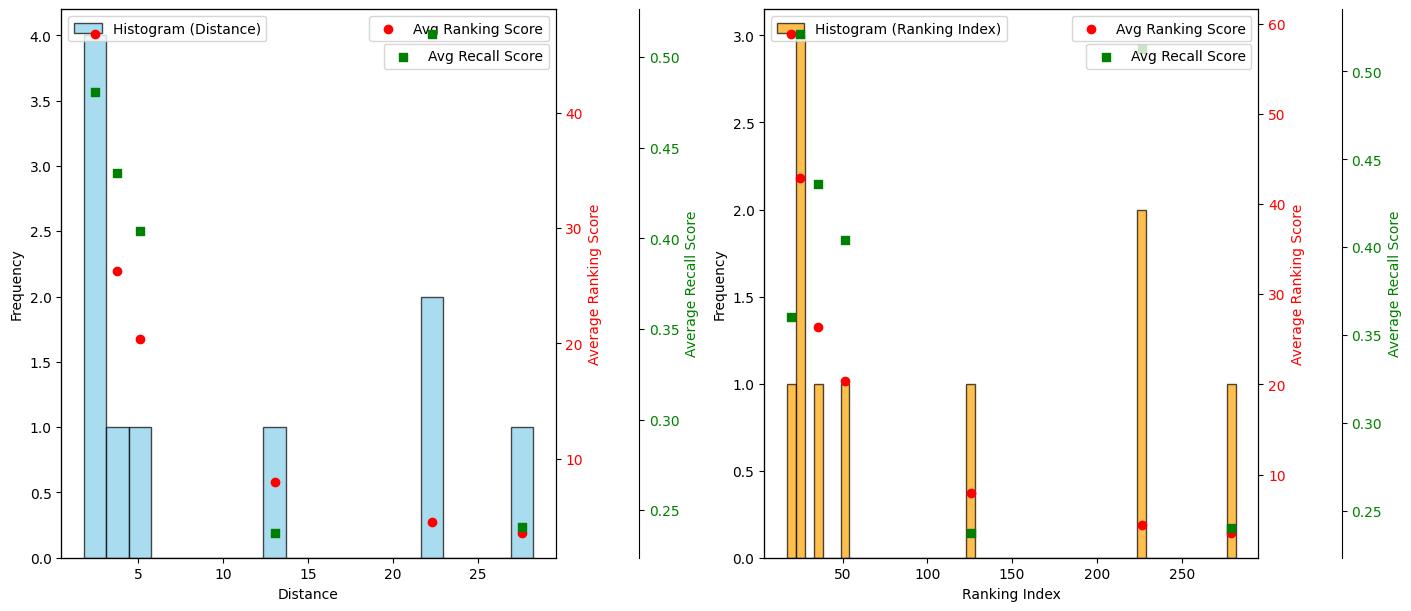

In [4]:
import matplotlib.pyplot as plt

# avg distance
distance_bin_size = 20
distance_bins = pd.cut(df["Distance"], bins=distance_bin_size)
distance_avg = df.groupby(distance_bins, observed=False).mean()
distance_midpoints = [interval.mid for interval in distance_bins.cat.categories]

# avg ranking index
ranking_index_bin_size = 50
ranking_index_bins = pd.cut(df["Ranking Index"], bins=ranking_index_bin_size)
ranking_index_avg = df.groupby(ranking_index_bins, observed=False).mean()
ranking_index_midpoints = [interval.mid for interval in ranking_index_bins.cat.categories]

# create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# first subplot: histogram by distance
ax1 = axes[0]
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))

# histogram for distance
ax1.hist(df["Distance"], bins=distance_bin_size, alpha=0.7, label="Histogram (Distance)", color="skyblue", edgecolor="black")
ax1.set_xlabel("Distance")
ax1.set_ylabel("Frequency")
ax1.legend(loc="upper left")

# line plots for ranking score and recall score
ax2.scatter(distance_midpoints, distance_avg["Ranking Score"], label="Avg Ranking Score", color="red", marker="o")
ax2.set_ylabel("Average Ranking Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.legend(loc="upper right")

ax3.scatter(distance_midpoints, distance_avg["Recall Score"], label="Avg Recall Score", color="green", marker="s")
ax3.set_ylabel("Average Recall Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")
ax3.legend(loc="upper right", bbox_to_anchor=(1.0, 0.95))


# second subplot: historgram by ranking index
ax4 = axes[1]
ax5 = ax4.twinx()
ax6 = ax4.twinx()
ax6.spines["right"].set_position(("outward", 60))

# histogram for ranking index
ax4.hist(df["Ranking Index"], bins=ranking_index_bin_size, alpha=0.7, label="Histogram (Ranking Index)", color="orange", edgecolor="black")
ax4.set_xlabel("Ranking Index")
ax4.set_ylabel("Frequency")
ax4.legend(loc="upper left")

# line plots for ranking score and recall score
ax5.scatter(ranking_index_midpoints, ranking_index_avg["Ranking Score"], label="Avg Ranking Score", color="red", marker="o")
ax5.set_ylabel("Average Ranking Score", color="red")
ax5.tick_params(axis='y', labelcolor="red")
ax5.legend(loc="upper right")

ax6.scatter(ranking_index_midpoints, ranking_index_avg["Recall Score"], label="Avg Recall Score", color="green", marker="s")
ax6.set_ylabel("Average Recall Score", color="green")
ax6.tick_params(axis='y', labelcolor="green")
ax6.legend(loc="upper right", bbox_to_anchor=(1.0, 0.95))

# show the plot
plt.show()
